In [1]:
import sys
#sys.path.append('C:/Users/Triphase.WS191692/Documents/Tripy')
#sys.path.append('/home/triphase')
import tripy as trp
%matplotlib inline

In [2]:
import ipywidgets as wid

class Render:
    """
    Class that wraps all necessary widgets
    """
    def select(description, options):
        widget = wid.Select(description = description, options = options)
        return widget

    def dropdown(description, options):
        widget = wid.Dropdown(description = description, options = options)
        return widget

    def select_multiple(description, options):
        widget = wid.SelectMultiple(description = description, options = options)
        return widget

    def button(text):
        widget = wid.Button(description = text)
        return widget

    def valid(boolean):
        widget = wid.Valid(value = boolean)
        return widget

    def html(string = ''):
        widget = wid.HTML(string)
        return widget

    def hbox(widget_list):
        widget = wid.HBox(children = widget_list)
        return widget

    def label(value):
        if isinstance(value, str):
            return wid.Label(value)

class Output:
    """
    Class that uses the html widget from the Render class to output a specific
    message (either feedback or an error) in a neater format.
    """
    def __init__(self):
        self.text_color = '#333333'
        self.tag_text_color = '#ffffff'
        self.border_color = '#eeeeee'
        self.background_color = '#f5f5f5'
        self.font = 'Verdana,sans-serif'
        self.box_r = '5px'
        self.tag_r = '3px'
        tmp_str = """<div style ='border-width: thin; color: {0}; border-style: solid; border-color: {1};
                            border-radius: {2} ; text-align: left; padding: 5px; padding-left: 5px;
                            padding-right: 5px; font-family: {3}; background-color: {4}'>""".format(self.text_color, self.border_color, self.box_r, self.font, self.background_color)
        tmp_str += "<table style = 'width: 100%'><tr><th></th></tr></table>"
        tmp_str += "<table style = 'width: 100%'><tr></tr></table></div>"
        self.html = tmp_str


    def __set_tag_color__(self, tag_type = ''):
        #colors from www.color-hex.com/color-palette/700
        #unused: yellow #ffc425 blue #00aedb
        if tag_type == 'error':
            tag_color = '#d11141'  #red
        elif tag_type == 'feedback':
            tag_color = '#00b159'  #green
        elif tag_type == 'warning':
            tag_color = '#f37735'  #orange
        else:
            tag_color = '#555555' #gray
        return tag_color


    def add_message(self, message):
        start_code, end_code = self.html.rsplit("</tr>", 1)
        tmp_str = start_code + "</tr><tr><td style ='padding-top: 10px'><p>{0}</p></td></tr>".format(message)
        tmp_str += end_code
        self.html = tmp_str

    def add_tag(self, tag_type = '', tag_str = ''):
        start_code, end_code = self.html.rsplit('<th></th>', 1)
        tmp_str = start_code + """<th><div style= 'border-radius: {0};
                                padding: 1px; padding-right: 5px; padding-left: 5px; text-align: left;
                                background-color: {1}; color: {2}; margin-right: 2px'><h5>{3}</h5></div></th>
                                <th></th>""".format(self.tag_r, self.__set_tag_color__(tag_type), self.tag_text_color, tag_str)
        tmp_str += end_code
        self.html = tmp_str


In [3]:
import sys, urllib.request
import socket as sckt
#import Render as r
from IPython.display import display as display
from IPython.display import clear_output as clear

class Target:
    def __init__(self, host, apache_port = 80, verbose = False):
        target_lib = self.find_targets(default_ip = host)
        if self.__check_target__(target_lib, host):
            self.host = host
        else:
            description = 'Select one of the available Triphase realtime targets: '
            pre_dict = []
            for i in range(len(target_lib['ips'])):
                pre_dict.append((target_lib['names'][i], target_lib['ips'][i]))
            options = dict(pre_dict)
            out = r.select(description, options)
            display(out)
            self.host = target_lib['ips'][0]
            out.on_trait_change(self.__change_host__, 'value')
            self.host = out.value
        self.apache_port = apache_port
        self.verbose = verbose
        self.version = sys.version_info[0]

    def __change_host__(self, name, value):
        self.host = value
        clear()
        print('Selected: ' + value)

    def find_targets(self, default_ip = '192.168.0.255', default_port = 8282):
        target_names = []
        target_ips = []
        s = sckt.socket(sckt.AF_INET, sckt.SOCK_DGRAM)
        s.setsockopt(sckt.SOL_SOCKET, sckt.SO_BROADCAST, 1)
        s.settimeout(0.1)
        string = 'GETHOSTNAME\0'
        out_data = string.encode('us-ascii')
        broadcast_ip = default_ip.rsplit('.', 1)[0] + '.255'
        #s.sendto(out_data, (broadcast_ip, default_port))
        s.sendto(out_data, ('172.22.151.35', default_port))
        while True:
            try:
                in_data, addr = s.recvfrom(256)
                target_names.append(in_data.decode())
                target_ips.append(addr[0])
            except sckt.error:
                break
        return {'ips' : target_ips, 'names' : target_names}

    def __check_target__(self, target_lib, ip):
        if type(ip) != 'str':
            ip = str(ip)
        if ip in target_lib['ips']:
            found = True
        else:
            found = False
        return found

    def perform_get(self, resource, command, properties = {}, api='/api/v1'):
        url = 'http://' + self.host
        url += api + '/' + resource + '.php'
        url += '?command=' + command
        for key, value in properties.items():
            url += '&' + key + '=' + value
        url = url.replace(' ', '+')
        if self.verbose:
            print ('log_url: {0}'.format(url))
        text = str(urllib.request.urlopen(url).read(), encoding='UTF-8')
        return text

    def add_message(self, type, title, content, sender):
        props = {'type': type, 'title': title, 'content': content, 'from': sender}
        text = self.perform_get('messages', 'addmessage', props, api="/gui")
        return text


In [4]:
class Fieldbus():
    def __init__(self, target, verbose = False):
        self.target = target
        self.verbose = verbose
        self.registers = self.target.perform_get('fieldbus', 'list').strip().split()[1:]

    def fieldbus_status(self):
        text = self.target.perform_get('fieldbus', 'status')
        # first line = number of registers
        lines = text.split('\n')[1:]
        values = {}
        for line in lines:
            lineValues = line.split()
            if len(lineValues) > 1:
                values[lineValues[1]] = lineValues[0]
        return values
        #add table print ==> tabulate

    def get_fieldbus_register(self, register):
        text = self.target.perform_get('fieldbus', 'get', {'register':register})
        if self.verbose == True:
            print('Fieldbus register {0} is equal to {1}'.format(register, text.strip()))
        return float(text.strip())

    def set_fieldbus_register(self, register, value):
        self.target.perform_get('fieldbus', 'set', {'register':register, 'value':str(value)})
        if self.verbose == True:
            print('Fieldbus register {0} set to {1}'.format(register, str(value)))


In [5]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
if matplotlib.__version__.split('.')[0] != '1':
    matplotlib.pyplot.Axes.set_axis_bgcolor = matplotlib.pyplot.Axes.set_facecolor
import matplotlib.gridspec as gs
import copy as cp

class Signal:
    def __init__(self, data, model, user, decimation, sample_time, content):
        self.timestamp = time.strftime('%Y.%m.%d/%H:%M:%S')
        self.decimation = decimation
        self.user = user
        self.sample_time = sample_time
        self.data = data
        self.content = content
        self.primary_tag = ''
        self.secondary_tag = ''
        self.version = 0.1
        self.info = {}

    def __zero_crossings__(self):
        out = self.__setup_dict__()
        idx = len(self.content)
        for i in range(idx):
            size = np.shape(self.data[self.content[i]])
            for j in range(size[1]):
                for z in range(size[0]-1):
                    if round(self.data[self.content[i]][z,j], 3)> 0:
                        if round(self.data[self.content[i]][z+1,j], 3)<= 0:
                            if np.shape(self.data[self.content[i]])[1] > 1:
                                out[self.content[i]][j].append(z)
                            else:
                                out[self.content[i]].append(z)
                    else:
                        if round(self.data[self.content[i]][z+1,j], 3)> 0:
                            if np.shape(self.data[self.content[i]])[1] > 1:
                                out[self.content[i]][j].append(z)
                            else:
                                out[self.content[i]].append(z)
        return out

    def __setup_dict__(self):
        idx = len(self.content)
        pre_dict = []
        for i in range(idx):
            n_col  = np.shape(self.data[self.content[i]])[1]
            if n_col == 1:
                pre_dict.append((self.content[i], []))
            else:
                pre_dict.append((self.content[i], [[] for i in range(n_col)]))
        return dict(pre_dict)

    def set_tag(self, tag):
        self.tag = tag

    def plot(self, title = '', har = []):
        #add a selector to the function
        #plt.style.use('fivethirtyeight')
        size = np.shape(self.data[self.content[0]])
        g = gs.GridSpec(len(self.data.keys()), 1, hspace = 0.3)
        if not har:
            fig = plt.figure(figsize = (12,len(self.content)*4))
            if title !='':
                fig.suptitle(title, fontsize=14)
            t = [i*self.decimation*self.sample_time for i in range(size[0])]
            for i in range(len(self.data.keys())):
                ax = plt.subplot(g[i, 0])
                ax.set_axis_bgcolor('w')
                ax.plot(t, self.data[self.content[i]], linewidth = 1)
                ax.set_xlabel('time [s]', fontsize = 14)
                ax.set_ylabel(self.content[i], fontsize = 14)
                ax.grid(alpha = 0.5, linestyle = 'solid', linewidth = 2, color = '0.75')
        else:
            fig = plt.figure(figsize = (12,len(self.content)*6), dpi = 600)
            props = []
            f = self.frequency()
            H = self.harmonic_content(f, har)
            for k in range(len(self.data.keys())):
                ax = plt.subplot(g[k, 0])
                if type(H[self.content[k]][0]) is list:
                    n_col = len(H[self.content[k]])
                else:
                    n_col = 1
                n_row = len(H['harmonics'])
                space = 0.05
                width = 0.1
                xloc = [[] for i in range(n_col)]
                height = [[] for i in range(n_col)]
                width_array = [[] for i in range(n_col)]
                if n_col%2 == 0:
                    index = []
                    for i in reversed(range(1,(n_col/2)+1)):
                        index.append(-i)
                    for i in range(1,(n_col/2)+1):
                        index.append(i)
                    for i in range(n_col):
                        for j in range(n_row):
                            if abs(index[i]) == 1:
                                xloc[i].append(H['harmonics'][j]+index[i]*(width+space/2)/2)
                            else:
                                xloc[i].append(H['harmonics'][j]+index[i]*(width/2+space))
                            height[i].append(H[self.content[k]][i][j])
                            width_array[i].append(width)
                else:
                    for i in range(n_col):
                        for j in range(n_row):
                            xloc[i].append(H['harmonics'][j]+(i-float((n_col-1)/2))*(space+0.15))
                            if n_col == 1:
                                height[i].append(H[self.content[k]][j])
                            else:
                                height[i].append(H[self.content[k]][i][j])
                            width_array[i].append(width)
                colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow']
                for i in range(n_col):
                    props.append([colors[i], 1, 'solid'])
                for i in range(n_col):
                    ax.bar(xloc[i], height[i], width_array[i], color = colors[i], align = 'center', edgecolor = colors[i], log = True)
                ax.grid(alpha = 0.5, linestyle = 'solid', linewidth = 1, color = '0.75')
                ax.set_axis_bgcolor('w')
                ax.set_xlabel('Harmonics', fontsize=14)
                ax.set_title(title)
                x_text = []
                for i in range(n_row):
                    x_text.append('H_'+str(int(H['harmonics'][i])))
                plt.xticks(H['harmonics'],x_text)


    def frequency(self):
        #to do:
        #------
        #rework the entire function ==> does not always yield good results.
        #implemented for every column of data ==> alter later
        #if __zero_crossings__ reports empty list ==> remove from output and notice user!
        index = self.__zero_crossings__()
        out = self.__setup_dict__()
        delta_index = []
        idx = len(self.content)
        for i in range(idx):
            n_col = np.shape(self.data[self.content[i]])[1]
            for j in range(n_col):
                if n_col == 1:
                    for z in range(len(index[self.content[i]])-1):
                        delta_index.append(index[self.content[i]][z+1] - index[self.content[i]][z])
                    out[self.content[i]].append(round(1/(np.mean(delta_index)*self.sample_time*self.decimation*2.0), 2))
                else:
                    for z in range(len(index[self.content[i]][j])-1):
                        delta_index.append(index[self.content[i]][j][z+1] - index[self.content[i]][j][z])
                    out[self.content[i]][j].append(round(1/(np.mean(delta_index)*self.sample_time*self.decimation*2.0), 2))
        return out

    def harmonic_content(self, frequency, harmonics = [1]):
        DC = False
        idx = len(self.content)
        pre_dict = []
        for i in range(idx):
            n_col  = np.shape(self.data[self.content[i]])[1]
            if n_col == 1:
                pre_dict.append((self.content[i], []))
            else:
                pre_dict.append((self.content[i], [[] for i in range(n_col)]))
        pre_dict.append(('harmonics', cp.deepcopy(harmonics)))
        out = dict(pre_dict)
        for i in range(idx):
            size = np.shape(self.data[self.content[i]])
            #create reference angle
            #assuming each entry of the dict has the same frequency
            theta = [0]
            freq = np.mean(frequency[self.content[i]])
            if harmonics[0] == 0:
                harmonics.pop(0)
                DC = True
            A = np.zeros((size[0],len(harmonics)*2))
            for j in range(size[0]-1):
                if theta[-1]>np.pi:
                    theta.append(theta[-1]+(2*np.pi*freq*self.decimation*self.sample_time)-(2*np.pi))
                else:
                    theta.append(theta[-1]+(2*np.pi*freq*self.decimation*self.sample_time))
                for h in range(len(harmonics)):
                    A[j,(2*h):(2*h)+2] = [np.cos(harmonics[h]*theta[-1]), -np.sin(harmonics[h]*theta[-1])]
            if DC:
                A = np.hstack((np.ones((size[0],1)), A))
            for k in range(size[1]):
                T = np.linalg.lstsq(A, self.data[self.content[i]][:,k])[0]
                if size[1] == 1:
                    if DC:
                        out[self.content[i]].append(T[0])
                        for z in range(len(harmonics)):
                            out[self.content[i]].append(np.sqrt(T[2*z+1]**2 + T[2*z+2]**2))
                    else:
                        for z in range(len(harmonics)):
                            out[self.content[i]].append(np.sqrt(T[2*z]**2 + T[2*z+1]**2))
                else:
                    if DC:
                        out[self.content[i]][k].append(T[0])
                        for z in range(len(harmonics)):
                            out[self.content[i]][k].append(np.sqrt(T[2*z+1]**2 + T[2*z+2]**2))
                    else:
                        for z in range(len(harmonics)):
                            out[self.content[i]][k].append(np.sqrt(T[2*z]**2 + T[2*z+1]**2))
        return out


In [6]:
import time
import numpy as np
from collections import OrderedDict as odict
#from .core.render import Render as r
#from .core.target import Target as t
#from .signal import Signal as s
from IPython.display import display as display

class Model:

    def __init__(self, model, host = '127.0.0.1', user= 'piet', target = None, model_port = 17726, verbose = False):
        """
        This is the starting point to connect to a compiled Simulink model on a Triphase realtime target.
        Once the connection is made you can start/stop a model and set/request data from blocks inside
        the compiled model. Do note that these blocks need to be 'External mode light' blocks.

        Basic usage:
        ------------
        m = tripy.Model(model='test_model', host='ip_address', user='user_name', model_port='17726')

        In order to create an instance of this class, only the model name and the user need to be set
        correctly. All other input parameters are set to default values.
        If a host is not specified, Triphase realtime targets will be automagically detected. You
        will be prompted with a list to choose from.
        """
        if target is None:
            target = t(host)
        self.target = target
        self.verbose = verbose
        self.model_port = str(model_port)
        self.model = model
        self.user = user
        self.running = False
        self.sample_time = 0.0
        self.overview = None
        self.signals = None
        self.parameters = None

    def __trim_url__(self, input_list):
        """
        Set up an dictionary of the string input list. The keys of this dictionary are trimmed to a
        more human readable format. The values of this dictionary are the full strings.
        """
        count = int(input_list[0])
        items = input_list[1:]
        work_list = []
        pre_dict = []
        full_url = []
        short_url = []
        layer = 2 #Set layer to 2: default is the item name + name of the subsystem one level up (if possible)
        for i in range(len(items)):
            work_list.append(items[i].split('/')[:-1])
        iterator = list(range(len(work_list)))
        while len(iterator) > 0:
            increment = False
            count_list = [[0] for i in range(len(iterator))]
            rm_list = []
            for i in iterator:
                tmp_list = list(range(len(work_list)))
                tmp_list.remove(i)
                for j in tmp_list:
                    try:
                        if work_list[i][-layer:] == work_list[j][-layer:]:
                            count_list[iterator.index(i)][-1] += 1
                    except IndexError:
                        print('IndexError')
            for i in range(len(count_list)):
                tmp_string = ''
                if count_list[i][-1] == 0:
                    if len(work_list[iterator[i]]) == 1:
                        loop_end = 2
                    else:
                        loop_end = layer + 1
                    for j in range(1, loop_end):
                        if j == 1:
                            tmp_string = work_list[iterator[i]][-j]
                        else:
                            tmp_string =  work_list[iterator[i]][-j] + '/' + tmp_string
                    short_url.append(tmp_string)
                    full_url.append(items[iterator[i]])
                    rm_list.append(iterator[i])
                else:
                    increment = True
            for i in range(len(rm_list)):
                iterator.remove(rm_list[i])
            if increment:
                layer += 1
        #Create dictionary.
        for i in range(len(full_url)):
                pre_dict.append((short_url[i], full_url[i]))
        if len(short_url) != count and len(full_url) != count:
            print('Error: \n The amount of items is not consistent.')
            return dict()
        else:
            return dict(pre_dict)

    def __handle_variables__(self, object, rdm_input = ''):
        """
        Handles either parameters or signals coming from a running model.
        Performs type casting and checks if the input matches the available
        list of either signals or parameters.
        """
        def __key_error_parameter__(variable):
            print('The following item ' + str(variable) + ' does not correspond to any item provided by the model.')
            print('Note that the no parameters will be set due to this error.')

        var_full = []
        var_short = []
        if type(rdm_input) is str:
            if len(rdm_input) == 0:
                for var in object.value:
                    for key in object.children[-1].options.keys():
                        if key + '/' in var:
                            var_short.append(key)
                            break
                    var_full.append(var)
            else:
                try:
                    var_full.append(object.children[-1].options[rdm_input])
                except KeyError:
                    __key_error_parameter__(rdm_input)
                var_short.append(rdm_input)
        elif type(rdm_input) is list:
            for var in rdm_input:
                try:
                    var_full.append(object.children[-1].options[var])
                except KeyError:
                    __key_error_parameter__(var)
                var_short.append(var)
        else:
            print('Unsupported input type. \n' + 'The supported types are string of list of strings.')
        return (var_short, var_full)

    def __check_running__(self):
        if self.status() == 'running':
            self.running = True
        else:
            self.running = False
        return self.running

    def status(self):
        """
        Provide information concerning the state of the model.
        """
        status = self.target.perform_get('model', 'status', {'port':self.model_port}).strip()
        return status

    def execution_time(self):
        """
        Provide the model execution time in seconds.
        """
        exec_time = self.target.perform_get('model', 'exectime', {'port':self.model_port}).strip()
        return float(exec_time)

    def start(self, quite = False):
        """
        Start the selected model on the Triphase realtime target. This method is necessary to set
        attributes of the created Model instance correctly, such as: available parameters/signals
        and the sample time Ts.

        Basic usage:
        ------------
        m.start()
        """
        if self.model == '':
            print('No model is currently selected.')
        else:
            _ = self.__check_running__()
            props = {'port':self.model_port, 'user':self.user, 'model':self.model}
            if not self.running:
                self.target.perform_get('model', 'start', props)
            time.sleep(1)
            for i in range(0,3):
                _ = self.__check_running__()
                if self.running:
                    options_p = self.__trim_url__(self.target.perform_get('model-parameters', 'list', {'port':self.model_port}).strip().split())
                    param_wid = r.hbox([r.label('Model parameters'), r.select_multiple(description='', options=options_p)])
                    self.parameters = param_wid
                    options_s = self.__trim_url__(self.target.perform_get('model-signals', 'list', {'port':self.model_port}).strip().split())
                    signal_wid = r.hbox([r.label('Model signals'), r.select_multiple(description='', options=options_s)])
                    self.signals = signal_wid
                    self.overview = r.hbox([signal_wid, param_wid])
                    self.sample_time = float(self.target.perform_get('model', 'sampletime', {'port':self.model_port}).strip())*1e-6
                    if not quite:
                        display(self.overview)
                    break
                else:
                    continue
                time.sleep(1)


    def stop(self):
        """
        Stop the selected model on the Triphase realtime target.
        """
        self.target.perform_get('model', 'stop', {'port':self.model_port})
        time.sleep(1)
        for i in range(2):
            _ = self.__check_running__()
            if not self.running:
                print ('The model: {0} has stopped.'.format(self.model))
                break
            else:
                print('The model: {0} is still running.'.format(self.model))
            time.sleep(1)

    def get_parameter(self, parameters = ''):
        """
        Request a parameter value from the running model.
        """
        pre_dict = []
        if self.__check_running__():
            param_short, param_full = self.__handle_variables__(self.parameters, parameters)
            #get parameter values, one by one
            for i in range(len(param_full)):
                props = {'port':self.model_port, 'name':param_full[i]}
                elements = self.target.perform_get('model-parameters', 'get', props).strip().split()
                if elements[0] is '1' and elements[1] is '1':
                    out = float(elements[-1])
                    pre_dict.append((param_short[i], out))
                else:
                    out = np.zeros((int(elements[0]), int(elements[1])))
                    index = 2
                    for j in range(int(elements[0])):
                        for k in range(int(elements[1])):
                            out[j,k] = float(elements[index])
                            index += 1
                    pre_dict.append((param_short[i], out))
        else:
            print('Error: The selected model is not running.')
        return dict(pre_dict)

    def set_parameter(self, parameters = '', values = 0.0):
        """
        Set parameter(s) value on a running model. Checks parameter and value integrity.
        """
        value_list = []
        #set inner_functions
        def __count_error__():
            print('Error: \n The number of parameters does not correspond to the number of values.')
            print('Note that the no parameters will be set due to this error.')

        def __type_error__(value):
            print('Error: \n The value input type: ' + str(type(value)) + ' is not supported. \n' + 'The supported types are integers, floats and numpy arrays.')
            print('Note that the no parameters will be set due to this error.')

        def __integrity_error__(parameter, value):
            if type(value) is float:
                print('Error: \n The parameter {0}'.format(parameter) + ' expects input type: ' + str(type(value)) + '.')
            else:
                size = np.shape(value)
                print('Error: \n The parameter {0}'.format(parameter) + ' expects input type: ' + str(type(value)) + ' with dimensions [{0}, {1}].'.format(size[0], size[1]))
            print('Note that the no parameters will be set due to this error.')

        #main
        if self.__check_running__():
            param_short, param_full = self.__handle_variables__(self.parameters, parameters)
            #check appropriate value types
            if type(values) is list:
                if len(param_full) == len(values):
                    for value in values:
                        if type(value) is int:
                            value_list.append(float(value))
                        elif type(value) is float:
                            value_list.append(value)
                        elif type(value) == np.ndarray:
                            value_list.append(value)
                        else:
                            __type_error__(value)
                            return
                else:
                    __count_error__()
            elif type(values) is int:
                value_list.append(float(values))
            elif type(values) is float:
                value_list.append(values)
            elif type(values) == np.ndarray:
                value_list.append(values)
            else:
                __type_error__(values)
                return
            #Set parameters one by one
            for i in range(len(param_full)):
                valid = False
                if type(value_list[i]) is float:
                    tmp = self.get_parameter(param_short[i])[param_short[i]]
                    if type(tmp) is float:
                        tmp_str = '1 1 ' + str(value_list[i]) + ' '
                        print('The parameter: {0} is set to {1}.'.format(param_short[i], value_list[i]))
                        valid = True
                    else:
                        __integrity_error__(param_short[i], tmp)
                        return
                else:
                    tmp = self.get_parameter(param_short[i])[param_short[i]]
                    if np.shape(value_list[i]) == np.shape(tmp):
                        n_row, n_col = np.shape(value_list[i])
                        tmp_str = str(n_row) + ' ' + str(n_col) + ' '
                        for j in range(n_row):
                            for k in range(n_col):
                                tmp_str= tmp_str + str(value_list[i][j,k]) + ' '
                        print('The parameter: {0} is set to the input array.'.format(param_short[i]))
                        valid = True
                    else:
                        __integrity_error__(param_short[i], tmp)
                        return
                if valid:
                    props = {'port' : self.model_port, 'name' : param_full[i], 'value' : tmp_str}
                    self.target.perform_get('model-parameters' , 'set', props)
        else:
            print('Error: The selected model is not running.')

    def get_signal(self, signals = ''):
        """
        Request a signal value from a running model.
        """
        pre_dict = []
        if self.__check_running__():
            sig_short, sig_full = self.__handle_variables__(self.signals, signals)
            #get signal one by one
            for i in range(len(sig_full)):
                props = {'port':self.model_port, 'name':sig_full[i]}
                elements = self.target.perform_get('model-signals', 'get', props).strip().split()
                if elements[0] is '1' and elements[1] is '1':
                    out = float(elements[-1])
                    pre_dict.append((sig_short[i], out))
                else:
                    out = np.zeros((int(elements[0]), int(elements[1])))
                    index = 2
                    for j in range(int(elements[0])):
                        for k in range(int(elements[1])):
                            out[j,k] = float(elements[index])
                            index += 1
                    pre_dict.append((sig_short[i], out))
        else:
            print('Error: The selected model is not running.')
        return dict(pre_dict)

    def __list_scopes__(self):
        """
        Generates a list of scopes currently used by the model. These are external mode light scopes, not to be confused
        with actual Mathworks Simulink scopes.
        """
        text = self.target.perform_get('model-scopes', 'list', {'port':self.model_port})
        names = text.strip().split()
        # first line = number of names
        return names[1:]

    def __create_scope__(self, name, signals, size, decimation):
        """
        Create a scope on the realtime target. Sets scope into idle mode.
        """
        signal_str = str(len(signals)) + " "
        for signal in signals:
            signal_str += signal + " "
        props = {'port':self.model_port, 'name':name, 'signals':signal_str, \
                'size':str(size), 'decimation':str(decimation)}
        text = self.target.perform_get('model-scopes', 'create', props)
        return text.strip()

    def __delete_scope__(self, name):
        """
        Delete a scope on the realtime target.
        """
        props = {'port':self.model_port, 'name':name}
        text = self.target.perform_get('model-scopes', 'delete', props)
        return text.strip()

    def __start_scope__(self, name):
        """
        Start an exisiting scope, hence capturing data.
        """
        props = {'port':self.model_port, 'name':name}
        text = self.target.perform_get('model-scopes', 'start', props)
        return text.strip()

    def __stop_scope__(self, name):
        """
        Set a scope back into idle mode.
        """
        props = {'port':self.model_port, 'name':name}
        text = self.target.perform_get('model-scopes', 'stop', props)
        return text.strip()

    def __get_scope_data__(self, name):
        """
        Retrieve the captured data from the realtime target.
        """
        props = {'port':self.model_port, 'name':name}
        elements = self.target.perform_get('model-scopes', 'get', props).strip().split()
        out = np.zeros((int(elements[0]), int(elements[1])))
        if elements[0] is '1' and elements[1] is '1':
            out[0,0] = float(elements[-1])
        else:
            index = 2
            for i in range(int(elements[0])):
                for j in range(int(elements[1])):
                    out[i,j] = float(elements[index])
                    index += 1
        return out

    def select_signal(self):
        """
        Select one or multiple signals with a neat widget.
        """
        wid = self.signals
        display(wid)

    def select_parameter(self):
        """
        Select one or multiple parameters with a neat widget.
        """
        wid = self.parameters
        display(wid)


    def capture_data(self, signals = '', samples = 1000, decimation = 1):
        """
        Wrapper function which uses the scope_functions in order to capture data from the realtime target.
        A scope is created, started, stopped and deleted in a function call. The function creates an instance of the
        Class Signal.
        """
        if self.__check_running__():
            sig_short, sig_full = self.__handle_variables__(self.signals, signals)
            size_list = []
            pre_dict = []
            for i in range(len(sig_full)):
                try:
                    size_list.append(np.shape(self.get_signal(sig_short[i])[str(sig_short[i])])[0])
                except IndexError:
                    size_list.append(1)
            scope_name = 'scope'
            Ts = self.sample_time
            self.__create_scope__(scope_name, sig_full, samples, decimation)
            self.__start_scope__(scope_name)
            time.sleep(samples*Ts*decimation*1.05)
            data_scope=self.__get_scope_data__(scope_name)
            self.__stop_scope__(scope_name)
            self.__delete_scope__(scope_name)
            for i in range(len(sig_short)):
                if i == 0:
                    pre_dict.append((sig_short[i], data_scope[:, 0:size_list[i]]))
                else:
                    pre_dict.append((sig_short[i], data_scope[:, sum(size_list[0:i]):sum(size_list[0:i+1])]))
            data = odict(pre_dict)

        else:
            print("The model is currently running on the target.")
            data = {}
        out = s(data, self.model, self.user, decimation, self.sample_time, sig_short)
        return out


<>:218: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:218: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:324: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:324: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:392: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:392: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:218: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:218: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:324: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:324: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:392: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:392: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-6-c863db7a4a74>:218: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if elements[0] is '1' and elements[1] is '1':
<ipython-input-6-c863db7a4a74>:218: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if elements[

In [7]:
m = trp.Model(model = 'PM15A30I60F06_afAC3_vsAC3_csDC1', user = 'piet', host = '172.22.151.35')
#m = trp.Model(model = 'C:/Users/Triphase.WS191692/Documents/Tripy/models/piet/src/PM15A30I60F06_afAC3_vsAC3_csDC1', user = 'piet', host = '172.22.151.35')

# Load Model

- The models are located in /home/triphase/models folder in the target pc. 
- The syntax looks like this:   

```Python

short_name_of_the_model = trp.Model(model = 'model_name', user = 'user_name', host = 'target_ip')

```

```Python

    - 'user_name' is the name of the folder on the target pc in /home/triphase/models (can be found using winSCP or Putty)
    - 'model_name' is the modeled which have been generated by Simulink and deploy to the target pc and can be found in               (/home/triphase/models/'user_name')

```




In [12]:
# Start the model

m.start()

#Stop the model

#m.stop()

# Model Signals and Model Parameters

In [13]:
# print the list of signal that can be monitored
m.select_signal()

In [14]:
# print the list of paramters that can be used.
m.select_parameter()

#### Capturing data

In [15]:
#capture a single signal
u_dcbus = m.get_signal('af/u_dcbus')
u_dcbus

{'af/u_dcbus': 9.094238}

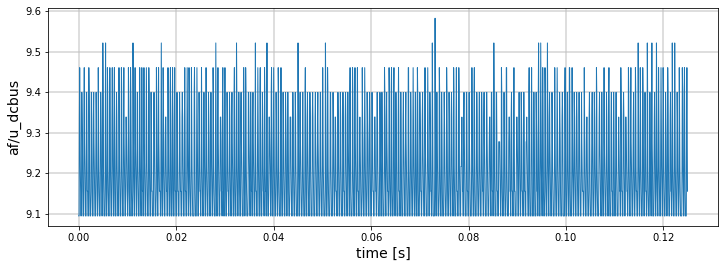

In [16]:
# capture 2000 data point and plot
u_dcbus = m.capture_data('af/u_dcbus', samples = 2000, decimation = 1)
u_dcbus.plot()

##### Parameters switching

    - An examaple is shown below:
        - 1st the external command need to be switched on.
        - 2nd Switch on the pre charge DC link.
        - Enale the Af.
        - Connect the transfomer.
        - Enable the current source.
        - Change SP to charge or discharge the battery.

In [17]:
# Enable the external command
m.set_parameter('COMMAND_CENTER/External_param', 1)

The parameter: COMMAND_CENTER/External_param is set to 1.0.


In [18]:
# switch on the pre charge 
m.set_parameter('syst/precharge_P30_1', 1)

The parameter: syst/precharge_P30_1 is set to 1.0.


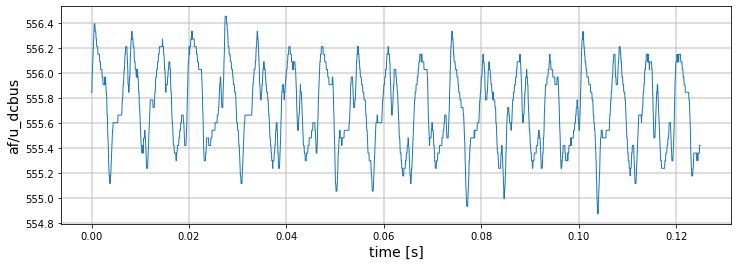

In [19]:
# check the DC bus voltage, it should be around 570 V 
u_dcbus = m.capture_data('af/u_dcbus', samples = 2000, decimation = 1)
u_dcbus.plot()

In [20]:
# enable the Af
m.set_parameter('af/enable', 1)

The parameter: af/enable is set to 1.0.


##### The pre charge can be switched off after the af has been connected

In [21]:
# The switch off the pre charge 
m.set_parameter('syst/precharge_P30_1', 0)

The parameter: syst/precharge_P30_1 is set to 0.0.


{'af/connected': 1.0}


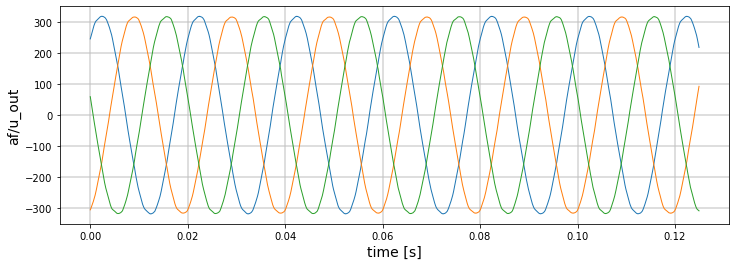

In [22]:
# capture output of Af
#capture a single signal
connect = m.get_signal('af/connected')
print(connect)
capture_data = m.capture_data('af/u_out', samples = 2000, decimation = 1)
capture_data.plot()

In [23]:
# connect the transfomer
m.set_parameter('transfo/connect', 1)

The parameter: transfo/connect is set to 1.0.


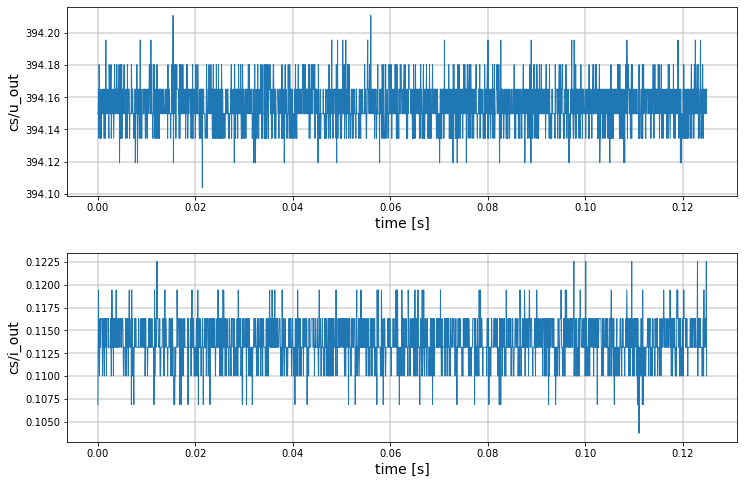

In [24]:
# capture output cs i and u out
cs_out = m.capture_data(['cs/u_out','cs/i_out'], samples = 2000, decimation = 1)
cs_out.plot()

In [25]:
# connect the cs
m.set_parameter('cs/enable', 1)

The parameter: cs/enable is set to 1.0.


# Important !!!!!

## Change the SP with small step and the setpoint value should smaller than 10 !!! 

    - Postive value: charge the battery.
    - Negative value: discharge from the battery.

In [26]:
# Change the current Set point
m.set_parameter('cs/i_ph', 1)

The parameter: cs/i_ph is set to 1.0.


### Plot a snapshot.

 - The plot show negative: charge the battery.
 - The plot show positive: discharge the battery.

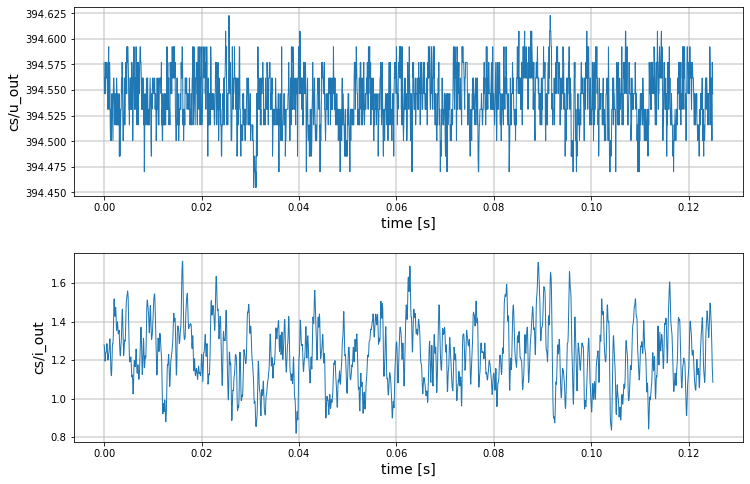

In [27]:
# capture output cs i and u out
cs_out = m.capture_data(['cs/u_out','cs/i_out'], samples = 2000, decimation = 1)
cs_out.plot()

# Turn off the system

- Follwing the step below:
        - Change the current SP back to 0.
        - Disconnect the cs.
        - Disconnect the transfomer.
        - Disable the Af.
        - Stop the model

In [28]:
# change the current SP back to 0
m.set_parameter('cs/i_ph', 0)

The parameter: cs/i_ph is set to 0.0.


In [29]:
# Disconnect the cs
m.set_parameter('cs/enable', 0)

The parameter: cs/enable is set to 0.0.


In [30]:
# Disconnect the transfomer
m.set_parameter('transfo/connect', 0)

The parameter: transfo/connect is set to 0.0.


In [31]:
# Disable the Af
m.set_parameter('af/enable', 0)

The parameter: af/enable is set to 0.0.


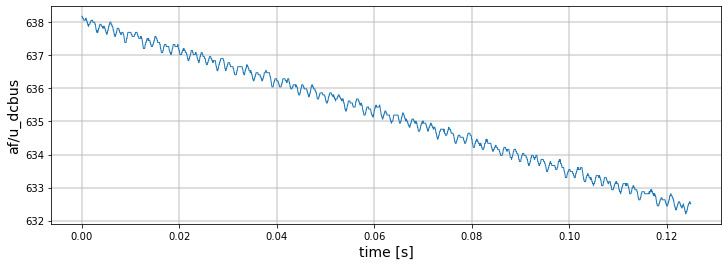

In [32]:
# check the DC bus voltage, it should be around 10 V 

u_dcbus = m.capture_data('af/u_dcbus', samples = 2000, decimation = 1)
u_dcbus.plot()

In [33]:
# Disable external command
m.set_parameter('COMMAND_CENTER/External_param', 0)

The parameter: COMMAND_CENTER/External_param is set to 0.0.


In [34]:
#Stop the model
m.stop()

The model: PM15A30I60F06_afAC3_vsAC3_csDC1 has stopped.


# Error Ack and Error check

In [ ]:
error_XC = m.get_signal('syst/error_XC')
error_XC
#error_s   = m.get_signal('syst/error_code_S')
#error_s

In [120]:
#set a single parameter
m.set_parameter('syst/error_ack', 1)
m.set_parameter('syst/error_ack', 0)

The parameter: syst/error_ack is set to 1.0.
The parameter: syst/error_ack is set to 0.0.


In [87]:
help(m.set_parameter)

Help on method set_parameter in module tripy.model:

set_parameter(parameters='', values=0.0) method of tripy.model.Model instance
    Set parameter(s) value on a running model. Checks parameter and value integrity.

